In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import os
import time as tm
import Sprayer_PDE as SP

import pypolo2

# Environment -- PINNS

In [2]:
# 初始化参数和环境污染浓度
Setting = pypolo2.utilities.Config()

In [3]:
# 确定存放地址
starttime = Setting.starttime.replace(' ', '-').replace(':', '-')
Savedir = '{}/{}/teamsize_{}'.format(Setting.root_dir,Setting.strategy_name,Setting.team_size)
Savename = 'seed{}'.format(Setting.seed)
Setting.save_dir = Savedir
Setting.save_name = Savename
evaluator = pypolo2.experiments.Evaluator()
logger = pypolo2.experiments.Logger(None, Setting)

# Sensor

In [4]:
sensor = pypolo2.sensors.Sprinkler(
    Setting = Setting
)

# Pilot Survey

In [5]:
rng = pypolo2.experiments.utilities.seed_everything(Setting = Setting)

Set random seed to 11 in random, numpy, and torch.


# Set initual data

In [6]:
# 初始化污染源
if Setting.randomsource == True:
    # gengerate two set of random numbers for source locations
    numbers = rng.randint(0, 19, size=Setting.sourcenum * 2)
    pairs = rng.choice(numbers, size=(Setting.sourcenum, 2), replace=False)
    for i in range(Setting.sourcenum):
        number = rng.randint(40, 70, size=1)
        Setting.RR[i,0] = int(pairs[i,0])
        Setting.RR[i,1] = int(pairs[i,1])
        Setting.RR[i,2] = number

s = 1
Setting.R =  -3 * np.ones((Setting.grid_x, Setting.grid_y)) + 6 * np.random.random((Setting.grid_x, Setting.grid_y))
for i in range(Setting.sourcenum):
        Setting.R[Setting.RR[i,0],Setting.RR[i,1]] = s*Setting.RR[i,2]

env_model = SP.Diffusion_Model(x_range = Setting.grid_x, y_range = Setting.grid_y,\
                 initial_field =  Setting.env, R_field =  Setting.R, data_sprayer_train = Setting.data_sprayer_train, t_start = 0) # build model
Setting.env = env_model.solve(10)[-1]
sensor.set_env(Setting.env)

# 初始化高斯过程回归需要的参数
env_model = SP.Diffusion_Model(x_range = Setting.grid_x, y_range = Setting.grid_y,\
                 initial_field =  Setting.env, R_field =  Setting.R, data_sprayer_train = Setting.data_sprayer_train, t_start = 0) # build model

y_init = np.zeros((Setting.num_init_samples,1))
y_stations = np.zeros((Setting.station_size*Setting.time_before_sche,1))
time_init = np.zeros((Setting.num_init_samples,1))
time_stations = np.zeros((Setting.station_size*Setting.time_before_sche,1))

for time in range(Setting.time_before_sche):
    time_stations[Setting.station_size*time:Setting.station_size*(time+1)] = (time-Setting.time_before_sche+1)*1
    Setting.env = env_model.solve((time+1)*5)[-1]
    sensor.set_env(Setting.env)
    
#假设每次观测后均变化时间，环境也随之发生变化
for time in range(Setting.num_init_samples):
    y_init[time] = sensor.sense(states=Setting.x_init[time], rng=rng).reshape(-1, 1)
    if time == 0:
        y_stations[:] = y_init[time] - 20
    time_init[time] = (time+1)*1
    Setting.env = env_model.solve((1+Setting.time_before_sche+time)*5)[-1]
    sensor.set_env(Setting.env)
    
Setting.x_init = np.hstack((Setting.x_init,time_init))

Setting.x_stations = Setting.x_station
for i in range(Setting.time_before_sche-1):
    Setting.x_stations = np.vstack((Setting.x_stations,Setting.x_station))
Setting.x_stations = np.hstack((Setting.x_stations,time_stations))

Setting.x_init = np.vstack((Setting.x_stations,Setting.x_init))
y_init = np.vstack((y_stations,y_init))

100%|██████████| 1.0/1.0 [00:00<00:00,  1.08it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.93it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.12it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.84it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.75it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.43it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.46it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.62it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.05it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.63it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  1.80it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.25it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.81it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.33it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.77it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.69it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.76it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.11it/s]    
100%|██████████| 1.0/1.0 [00

# Model

In [7]:
Setting.time_stamp = Setting.x_init[:,2].max(axis=0, keepdims=False)
kernel = pypolo2.kernels.RBF(Setting)
model = pypolo2.models.GPR(
    x_train=Setting.x_init,
    y_train=y_init,
    kernel=kernel,
    noise=Setting.init_noise,
    lr_hyper=Setting.lr_hyper,
    lr_nn=Setting.lr_nn,
    is_normalized = True,
    time_stamp = Setting.time_stamp,
)

In [8]:
model.optimize(num_iter=model.num_train, verbose=True)

Iter: 05 loss:  8.64: 100%|██████████| 6/6 [00:00<00:00, 69.54it/s]


# Robot

In [9]:
vehicle_team = dict()
for i in range(Setting.team_size):
    robot = pypolo2.robots.SPRINKLER_REPLENISHANYWHERE(
        init_state = np.array([Setting.x_init[-1, 0], Setting.x_init[-1, 1]]),
        Setting = Setting
    )
    vehicle_team[i+1] = robot #因此team的id从1开始

# Strategy

In [10]:
strategy = pypolo2.strategies.MCTSSpray(
            task_extent=Setting.task_extent,
            rng=rng,
            vehicle_team=vehicle_team,
        )
Setting.strategy = strategy

# Experiment

In [11]:
#定义需要随时间更新的训练过程
def run(rng, model, Setting, sensor, evaluator, logger, vehicle_team) -> None:
    current_step = 0 #总规划长度
    adaptive_step = Setting.adaptive_step #自适应长度
    change_step = 0
    spray_effect = 0 # 洒水效果
    result, MI_information, observed_env, computed_effect = None, None, None, None
    tstart = 0
    while current_step < Setting.max_num_samples:
        # 计算用于洒水效果,环境真实值已知
        allpoint_list = []
        env_list = []
        for i in range (Setting.task_extent[0],Setting.task_extent[1]):
            for j in range (Setting.task_extent[2],Setting.task_extent[3]):
                allpoint_list.append([i, j, model.time_stamp])
                env_list.append(Setting.env[i,j])
        allpoint = np.array(allpoint_list)
        env = np.array(env_list)
        mean, _ = model(allpoint)
        sprayeffect_all = pypolo2.objectives.sprayeffect.spray_effect(allpoint, allpoint, mean, Setting.task_extent).ravel()
        prior_diag_std, poste_diag_std, _, _ = model.prior_poste(allpoint)
        hprior = pypolo2.objectives.entropy.gaussian_entropy(prior_diag_std.ravel())
        hposterior = pypolo2.objectives.entropy.gaussian_entropy(poste_diag_std.ravel())
        mi_all = hprior - hposterior
        if np.any(mi_all < 0.0):
            print(mi_all.ravel())
            raise ValueError("Predictive MI < 0.0!")
        
        sprayeffect_all = pypolo2.objectives.sprayeffect.spray_effect(allpoint, allpoint, env, Setting.task_extent).ravel()
        MI_information = np.zeros((Setting.task_extent[1]-Setting.task_extent[0],Setting.task_extent[3]-Setting.task_extent[2]))
        observed_env = np.zeros((Setting.task_extent[1]-Setting.task_extent[0],Setting.task_extent[3]-Setting.task_extent[2]))
        computed_effect = np.zeros((Setting.task_extent[1]-Setting.task_extent[0],Setting.task_extent[3]-Setting.task_extent[2]))
        for i in range (Setting.task_extent[0],Setting.task_extent[1]):
            for j in range (Setting.task_extent[2],Setting.task_extent[3]):
                MI_information[i,j] = mi_all[i*(Setting.task_extent[3]-Setting.task_extent[2])+j]
                observed_env[i,j] = Setting.env[i,j]
                computed_effect[i,j] = sprayeffect_all[i*(Setting.task_extent[3]-Setting.task_extent[2])+j]
                
        Setting.current_step = current_step
        
        
        # scheduling and update agent goals ###################################################
        if adaptive_step >= Setting.adaptive_step:
            start = tm.time()
            result = Setting.strategy.get(model = model, Setting = Setting, pred = observed_env)
            print(result)
            adaptive_step = 0
            for id, vehicle in vehicle_team.items():
                vehicle.set_goals(result[id][0],result[id][1])
            end = tm.time()
            print('search_time')
            print(end-start)    
            
        # calculate metrix and save 
        coverage, mean_airpollution, max_airpollution = evaluator.eval_results(Setting.env, Setting.task_extent, vehicle_team)
        logger.append(current_step, Setting.env, observed_env, MI_information, computed_effect, vehicle_team, coverage, mean_airpollution, max_airpollution, spray_effect)
           
        # change source,每经过R_change_interval后，改变源分布和强度，
        if change_step >= Setting.R_change_interval:
            Setting.R =  -3 * np.ones((Setting.grid_x, Setting.grid_y)) + 6 * np.random.random((Setting.grid_x, Setting.grid_y))
            change_step = 0
            if Setting.randomsource == True:
                # gengerate two set of random numbers for source locations
                numbers = rng.randint(0, 4, size=Setting.sourcenum * 2)
                pairs = rng.choice(numbers, size=(Setting.sourcenum, 2), replace=False)
                for i in range(Setting.sourcenum):
                    number = rng.randint(40, 70, size=1)
                    # number= 200
                    # Setting.RR[i,0] = int(pairs[i,0])
                    # Setting.RR[i,1] = int(pairs[i,1])
                    if Setting.RR[i,0]+pairs[i,0]-2 < Setting.grid_x-1 and Setting.RR[i,0] + pairs[i,0] - 2 >=0:
                        Setting.RR[i,0] = int(Setting.RR[i,0]+pairs[i,0]-2)
                    if Setting.RR[i,1]+pairs[i,1]-2 < Setting.grid_y-1 and Setting.RR[i,1] + pairs[i,1] - 2 >=0:
                        Setting.RR[i,1] = int(Setting.RR[i,1]+pairs[i,1]-2)
                    Setting.RR[i,2] = number
                tstart = current_step

        s = 1
        for i in range(Setting.sourcenum):
             Setting.R[Setting.RR[i,0],Setting.RR[i,1]] = s*Setting.RR[i,2]
        # import sys
        # sys.exit()
        
        # 执行规划结果并推进仿真环境
        # 计算无洒水时的环境分布，推进表步长为1分钟
        env_model1 = SP.Diffusion_Model(x_range = Setting.grid_x, y_range = Setting.grid_y,\
                initial_field = Setting.env, R_field =  Setting.R, data_sprayer_train = Setting.data_sprayer_train, t_start = current_step * Setting.delta_t)
        env_withoutspray = env_model1.solve(Setting.delta_t)[-1]
            
        # update state 并将车辆的轨迹和洒水轨迹取出来
        x_new = []
        y_new = []
        for id, vehicle in vehicle_team.items():
            vehicle.update()
            current_state = vehicle.state.copy().reshape(1, -1)
            x_new.append(current_state)
            y_new.append(sensor.sense(current_state, rng).reshape(-1, 1))
            if Setting.current_step == 0:
                Setting.data_sprayer_train.append(pd.DataFrame())
            if vehicle.spray_flag == True:
                new_pd = pd.DataFrame({"time":(Setting.current_step + 1) * Setting.delta_t, "x":current_state[0,0],\
                                        "y":current_state[0,1], "spray_volume":200},index=[0])
                Setting.data_sprayer_train[id-1] = pd.concat([Setting.data_sprayer_train[id-1],new_pd])
            else:
                new_pd = pd.DataFrame({"time":(Setting.current_step + 1) * Setting.delta_t, "x":current_state[0,0],\
                                        "y":current_state[0,1], "spray_volume":0},index=[0])
                Setting.data_sprayer_train[id-1] = pd.concat([Setting.data_sprayer_train[id-1],new_pd])    
        # 计算带入洒水后的环境情况
        env_model2 = SP.Diffusion_Model(x_range = Setting.grid_x, y_range = Setting.grid_y,\
                initial_field =  Setting.env, R_field =  Setting.R, data_sprayer_train = Setting.data_sprayer_train, t_start = current_step * Setting.delta_t) # build model
        env_withspray = env_model2.solve(Setting.delta_t)[-1]
        
        # 疑似污染源标记
        for id, vehicle in vehicle_team.items():
            current_state = vehicle.state.copy().reshape(1, -1).astype(int)
            # 如果当前状态在污染源四周，则认为已经发现了
            for i in range(Setting.sourcenum):
                # 判断是否在周围
                if ((current_state[0,0]-Setting.RR[i,0])**2 + (current_state[0,1]-Setting.RR[i,1])**2) <= 2:
                    # 判断是否已经发现
                    in_flag = False
                    for j in range(len(Setting.sources)):
                        if Setting.RR[i,0] == Setting.sources[j][0] and Setting.RR[i,1] == Setting.sources[j][1]:
                            in_flag = True
                    if in_flag:
                        continue
                    else:
                        Setting.sources.append([Setting.RR[i,0], Setting.RR[i,1]])         
                        
        print(Setting.sources)   
        Setting.env = env_withspray
        sensor.set_env(Setting.env)
        # 移除污染标记
        for i in range(len(Setting.sources)-1, -1, -1):
            if Setting.env[Setting.sources[i][0],Setting.sources[i][1]] <= 45:
                del Setting.sources[i]    
        
        # 计算洒水效果
        spray_effect = np.sum(env_withoutspray - Setting.env)
        print(spray_effect)
            
        # using new data to update gpr model
        x_new = np.concatenate(x_new, axis=0)
        y_new = np.concatenate(y_new, axis=0)
        #add time dim
        model.time_stamp = model.time_stamp + Setting.time_co
        Setting.time_stamp = model.time_stamp
        model_input = np.zeros((x_new.shape[0],3))
        model_input[:,0:2] = x_new
        model_input[:,2:3] = model.time_stamp
        #optimize model
        model.add_data(model_input, y_new)
        model.optimize(num_iter=len(y_new), verbose=False)
        
        adaptive_step = adaptive_step + 1     
        current_step = current_step + 1
        change_step = change_step + 1  
    return 0

In [12]:
start = tm.time()
Setting.strategy = strategy
run(rng, model, Setting, sensor, evaluator, logger, vehicle_team)
# pypolo2.experiments.utilities.print_metrics(logger, Setting.max_num_samples-1)
end = tm.time()
# logger.save(end-start)  # I temporarily removed "makefile()".

[[10. 10.]
 [10. 10.]
 [10. 10.]
 [10. 10.]]
4
[6, 6, 6, 6, 6, 6, 6, 0, 3, 6, 0, 1, 0, 0, 3, 1] 800.8510722721351
{1: (array([[11.,  9.],
       [12.,  8.],
       [12.,  7.],
       [11.,  6.],
       [11.,  6.],
       [11.,  6.],
       [11.,  6.],
       [11.,  6.]]), array([[ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.]])), 2: (array([[11.,  9.],
       [12.,  8.],
       [13.,  7.],
       [12.,  6.],
       [12.,  6.],
       [12.,  6.],
       [12.,  6.],
       [12.,  6.]]), array([[ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.]])), 3: (array([[11.,  9.],
       [12.,  8.],
       [11.,  7.],
       [11.,  6.],
       [11.,  6.],
       [11.,  6.],
       [11.,  6.],
       [11.,  6.]]), array([[ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.]])), 4: (array([[11.,  9.],
       [10.,  8.],
       [ 9.,  8.],
     

100%|██████████| 1.0/1.0 [00:00<00:00,  1.73it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.28it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.99it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.62it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.84it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.86it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.19it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.41it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.59it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.53it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  1.64it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.92it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.69it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.77it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.30it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.10it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.40it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.65it/s]    
100%|██████████| 1.0/1.0 [00

[]
0.0


100%|██████████| 1.0/1.0 [00:00<00:00,  1.79it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.41it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.56it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.30it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.71it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.52it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.49it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  5.67it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.59it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  6.50it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  1.50it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.83it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.74it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.00it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.87it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.98it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.85it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.87it/s]    
100%|██████████| 1.0/1.0 [00

[[12, 7]]
2230.8429553859296


100%|██████████| 1.0/1.0 [00:00<00:00,  1.45it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.80it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.92it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.93it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.78it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.95it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.98it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.79it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.69it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.73it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  1.23it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.62it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.97it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.04it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.94it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.06it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.27it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.19it/s]    
100%|██████████| 1.0/1.0 [00

[[12, 7]]
1155.8888096169185


100%|██████████| 1.0/1.0 [00:00<00:00,  1.19it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.01it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.07it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.22it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.08it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.39it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.12it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.68it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.63it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.71it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  1.83it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  4.05it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.88it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.64it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.88it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.25it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.98it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.31it/s]    
100%|██████████| 1.0/1.0 [00

[[12, 7], [11, 5]]
850.0583374005937


100%|██████████| 1.0/1.0 [00:00<00:00,  1.46it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.59it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.61it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.49it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.14it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.29it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.33it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.12it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.24it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.62it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  1.50it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.18it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.13it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.14it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.14it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.82it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.89it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.84it/s]    
100%|██████████| 1.0/1.0 [00

[[11, 5]]
455.6716926080086


100%|██████████| 1.0/1.0 [00:00<00:00,  1.47it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.87it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.91it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.80it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.24it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.24it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.33it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.23it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.16it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.27it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  1.29it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.33it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.92it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.04it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.13it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.12it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.05it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.08it/s]    
100%|██████████| 1.0/1.0 [00

[[11, 5]]
-2.2082350740596404


100%|██████████| 1.0/1.0 [00:00<00:00,  1.42it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.97it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.20it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.10it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.16it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.38it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.25it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.39it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.33it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.07it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  1.38it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.05it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.96it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.18it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.78it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.97it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.85it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.03it/s]    
100%|██████████| 1.0/1.0 [00

[[11, 5]]
-1.2669351591525366


100%|██████████| 1.0/1.0 [00:00<00:00,  1.45it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.22it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.89it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.25it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.21it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.98it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.15it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.04it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.21it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.28it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  1.59it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.24it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.98it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.41it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.52it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.28it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.28it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.31it/s]    
100%|██████████| 1.0/1.0 [00

[[11, 5]]
0.0
[[11.  6.]
 [12.  6.]
 [11.  6.]
 [ 8.  8.]]
4
[0, 0, 0, 6, 3, 0, 6, 6, 3, 3, 1, 3, 4, 4, 5, 3] 751.834720251088
{1: (array([[10.,  5.],
       [10.,  4.],
       [10.,  3.],
       [10.,  3.],
       [10.,  3.],
       [10.,  3.],
       [10.,  3.],
       [10.,  3.]]), array([[ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.]])), 2: (array([[11.,  5.],
       [10.,  4.],
       [10.,  3.],
       [10.,  3.],
       [10.,  3.],
       [10.,  3.],
       [10.,  3.],
       [10.,  3.]]), array([[ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.]])), 3: (array([[10.,  5.],
       [11.,  4.],
       [10.,  4.],
       [10.,  5.],
       [10.,  5.],
       [10.,  5.],
       [10.,  5.],
       [10.,  5.]]), array([[ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.]])), 4: (array([[ 9.,  7.],
       [10.,  6.],
       [10.

100%|██████████| 1.0/1.0 [00:00<00:00,  1.76it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.62it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.56it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.50it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.53it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.26it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.97it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.21it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.25it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.96it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  1.59it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.32it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.26it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.54it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.00it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.17it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.18it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.10it/s]    
100%|██████████| 1.0/1.0 [00

[[11, 5], [10, 4]]
1311.6048743508538


100%|██████████| 1.0/1.0 [00:00<00:00,  1.45it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.89it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.20it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.29it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.69it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.69it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.72it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.52it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.60it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.31it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  1.74it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.00it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.29it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.43it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.36it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.10it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.38it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.19it/s]    
100%|██████████| 1.0/1.0 [00

[[10, 4]]
1009.6019805007575


100%|██████████| 1.0/1.0 [00:00<00:00,  1.20it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.85it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.94it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.03it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.79it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.68it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.51it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.64it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.20it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.51it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  1.33it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.84it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.46it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.44it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.31it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.69it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.66it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.47it/s]    
100%|██████████| 1.0/1.0 [00

[[10, 2]]
864.062702684374


100%|██████████| 1.0/1.0 [00:00<00:00,  1.26it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.49it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.35it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.27it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.51it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.79it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.14it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.30it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.56it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.79it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  1.28it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.75it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.79it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.79it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.82it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.86it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.87it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.76it/s]    
100%|██████████| 1.0/1.0 [00

[[10, 2]]
775.7372791563407


100%|██████████| 1.0/1.0 [00:00<00:00,  1.28it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.76it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.47it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.85it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  1.96it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.79it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.58it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.93it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.24it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.21it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  1.41it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.40it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.17it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.35it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.52it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.83it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.52it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.79it/s]    
100%|██████████| 1.0/1.0 [00

[[10, 2]]
456.489857487486


100%|██████████| 1.0/1.0 [00:00<00:00,  1.25it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.12it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.87it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.60it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.79it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.93it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.71it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.94it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.80it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.34it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  1.07it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.70it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.53it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.28it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.36it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.47it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.27it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.37it/s]    
100%|██████████| 1.0/1.0 [00

[]
1.5098913298316399


100%|██████████| 1.0/1.0 [00:00<00:00,  1.17it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.39it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.85it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.59it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.72it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.54it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  1.65it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.66it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.76it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.02it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  1.04it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.61it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.30it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.95it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.75it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.77it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.03it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.91it/s]    
100%|██████████| 1.0/1.0 [00

[]
0.0


100%|██████████| 1.0/1.0 [00:00<00:00,  1.36it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.76it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.81it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.98it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.94it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.08it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.28it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.13it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.13it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.16it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  1.52it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.01it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.79it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.52it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.94it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.87it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.45it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.97it/s]    
100%|██████████| 1.0/1.0 [00

[]
0.8573100987704265
[[10.  3.]
 [10.  3.]
 [10.  5.]
 [10.  4.]]
4
[0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 6, 2, 2, 0, 4] 1200.9248099488116
{1: (array([[9., 2.],
       [8., 1.],
       [7., 0.],
       [6., 1.],
       [6., 1.],
       [6., 1.],
       [6., 1.],
       [6., 1.]]), array([[ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.]])), 2: (array([[9., 2.],
       [8., 1.],
       [7., 0.],
       [6., 1.],
       [6., 1.],
       [6., 1.],
       [6., 1.],
       [6., 1.]]), array([[ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.]])), 3: (array([[9., 4.],
       [8., 3.],
       [7., 2.],
       [6., 1.],
       [6., 1.],
       [6., 1.],
       [6., 1.],
       [6., 1.]]), array([[ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.]])), 4: (array([[10.,  3.],
       [ 9.,  2.],
       [10.,  1.],
       [10.,  1.],
       [10.

100%|██████████| 1.0/1.0 [00:00<00:00,  1.44it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.05it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.86it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.06it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.13it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.03it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.80it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.90it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.69it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.89it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  1.41it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.71it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.78it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.88it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.94it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.62it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.95it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.74it/s]    
100%|██████████| 1.0/1.0 [00

[]
1582.3347068862017


100%|██████████| 1.0/1.0 [00:00<00:00,  1.03it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.06it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.97it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.09it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.11it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.80it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.94it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.05it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.09it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.01it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  1.54it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.05it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.30it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.03it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.02it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.25it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.33it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.33it/s]    
100%|██████████| 1.0/1.0 [00

[[7, 0]]
1243.9940097713165


100%|██████████| 1.0/1.0 [00:00<00:00,  1.52it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.24it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.09it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.91it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.13it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.07it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.69it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.11it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.91it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.06it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  1.51it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.94it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.16it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.92it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.29it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.16it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.43it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.23it/s]    
100%|██████████| 1.0/1.0 [00

[[7, 0]]
778.4353298728219


100%|██████████| 1.0/1.0 [00:00<00:00,  1.45it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.91it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.15it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.01it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.08it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.13it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.14it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.06it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.22it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.07it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  1.48it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.85it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.06it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.09it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.92it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.89it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.00it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.94it/s]    
100%|██████████| 1.0/1.0 [00

[[7, 0]]
653.7409886200222


100%|██████████| 1.0/1.0 [00:00<00:00,  1.48it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.63it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.03it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.06it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.91it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.99it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.86it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.93it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.03it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.09it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  1.46it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.17it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.94it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.26it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.29it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.40it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.56it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.31it/s]    
100%|██████████| 1.0/1.0 [00

[[7, 0]]
379.5709296606035


100%|██████████| 1.0/1.0 [00:00<00:00,  1.46it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.11it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.43it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.04it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.24it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.58it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.32it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.44it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.32it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.26it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  1.26it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.99it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.97it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.80it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.96it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.90it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.97it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.96it/s]    
100%|██████████| 1.0/1.0 [00

[[7, 0], [7, 1]]
-1.601830625497314


100%|██████████| 1.0/1.0 [00:00<00:00,  1.40it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.00it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.77it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.98it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.89it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.02it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.06it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.06it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.10it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.06it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  1.51it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.86it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.99it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.76it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.03it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.09it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.89it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.81it/s]    
100%|██████████| 1.0/1.0 [00

[[7, 0], [7, 1]]
-2.331558139117588


100%|██████████| 1.0/1.0 [00:00<00:00,  1.29it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.92it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.03it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.96it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.01it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.02it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.03it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.15it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.84it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.06it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  1.41it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.92it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.71it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.82it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.90it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.93it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  1.78it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.30it/s]    
100%|██████████| 1.0/1.0 [00

[[7, 0], [7, 1]]
0.7541258859140694
[[ 6.  1.]
 [ 6.  1.]
 [ 6.  1.]
 [10.  1.]]
4
[6, 7, 7, 0, 8, 3, 3, 5, 1, 5, 5, 3, 1, 4, 4, 7] 723.695682623568
{1: (array([[7., 0.],
       [8., 1.],
       [7., 1.],
       [6., 1.],
       [6., 1.],
       [6., 1.],
       [6., 1.],
       [6., 1.]]), array([[ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.]])), 2: (array([[7., 1.],
       [7., 0.],
       [7., 1.],
       [7., 1.],
       [7., 1.],
       [7., 1.],
       [7., 1.],
       [7., 1.]]), array([[ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.]])), 3: (array([[7., 1.],
       [7., 0.],
       [7., 1.],
       [7., 1.],
       [7., 1.],
       [7., 1.],
       [7., 1.],
       [7., 1.]]), array([[ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.]])), 4: (array([[ 9.,  0.],
       [ 9.,  1.],
       [ 9.,  0.],
       [10.,  0.],

100%|██████████| 1.0/1.0 [00:00<00:00,  1.00it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.64it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.75it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.47it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  1.84it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.19it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.23it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.24it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  1.75it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.39it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  1.31it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.44it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.77it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.01it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.13it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.09it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.18it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.10it/s]    
100%|██████████| 1.0/1.0 [00

[[7, 0], [7, 1], [8, 1]]
1078.4560823378617


100%|██████████| 1.0/1.0 [00:00<00:00,  1.46it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.11it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.94it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.21it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.96it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.43it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.20it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.94it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.30it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.08it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  1.61it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.21it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.30it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.73it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.80it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.03it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.14it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.42it/s]    
100%|██████████| 1.0/1.0 [00

[[8, 1]]
660.291853923851


100%|██████████| 1.0/1.0 [00:00<00:00,  1.52it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.31it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.59it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.60it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.48it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.33it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.58it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.19it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.98it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.11it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  1.24it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.80it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.18it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.33it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.15it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.55it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.28it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.68it/s]    
100%|██████████| 1.0/1.0 [00

[[8, 1]]
494.6870223545436


100%|██████████| 1.0/1.0 [00:00<00:00,  1.54it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.77it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.15it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.97it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.16it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.29it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.00it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.21it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.19it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.36it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  1.63it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.44it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.55it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.39it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.67it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.52it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.49it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.54it/s]    
100%|██████████| 1.0/1.0 [00

[[8, 1], [6, 2]]
528.3178333478785


100%|██████████| 1.0/1.0 [00:00<00:00,  1.62it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.17it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.56it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.53it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.38it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.49it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.63it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.46it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.50it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.53it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  1.55it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.01it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.13it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  1.87it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.54it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.08it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.27it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.14it/s]    
100%|██████████| 1.0/1.0 [00

[[6, 2]]
386.4405658540433


100%|██████████| 1.0/1.0 [00:01<00:00,  1.10s/it]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.27it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.18it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.32it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.13it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.35it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.47it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.70it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.53it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.55it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  1.76it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.18it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.35it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.50it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.56it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.34it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.72it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.12it/s]    
100%|██████████| 1.0/1.0 [00

[[6, 2]]
0.0


100%|██████████| 1.0/1.0 [00:00<00:00,  1.40it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.25it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.29it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.40it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.49it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.37it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.46it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.63it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.48it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.48it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  1.56it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.34it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.00it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.77it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.35it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.18it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.29it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.07it/s]    
100%|██████████| 1.0/1.0 [00

[[6, 2], [7, 2]]
0.9803544774591311


100%|██████████| 1.0/1.0 [00:00<00:00,  1.58it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.28it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.33it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.95it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.50it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.45it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.40it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.45it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.73it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.68it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  1.37it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.56it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.62it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.00it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.18it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.51it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.50it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.68it/s]    
100%|██████████| 1.0/1.0 [00

[[6, 2], [7, 2]]
-0.9513801958150268
[[ 6.  1.]
 [ 7.  1.]
 [ 7.  1.]
 [10.  0.]]
4
[8, 8, 8, 5, 8, 8, 8, 8, 1, 5, 8, 5, 0, 2, 2, 2] 1674.1094114236605
{1: (array([[7., 2.],
       [8., 3.],
       [7., 3.],
       [6., 2.],
       [6., 2.],
       [6., 2.],
       [6., 2.],
       [6., 2.]]), array([[ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.]])), 2: (array([[8., 2.],
       [9., 3.],
       [9., 4.],
       [8., 5.],
       [8., 5.],
       [8., 5.],
       [8., 5.],
       [8., 5.]]), array([[ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.]])), 3: (array([[ 8.,  2.],
       [ 9.,  3.],
       [10.,  4.],
       [ 9.,  5.],
       [ 9.,  5.],
       [ 9.,  5.],
       [ 9.,  5.],
       [ 9.,  5.]]), array([[ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.]])), 4: (array([[10.,  1.],
       [11.,  2.],
       [11.,  3.],

100%|██████████| 1.0/1.0 [00:00<00:00,  1.62it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.83it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.16it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.38it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.17it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.27it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.18it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.11it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.08it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.13it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  1.40it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.03it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.97it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.10it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.19it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.08it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.99it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.17it/s]    
100%|██████████| 1.0/1.0 [00

[[6, 2], [7, 2]]
2401.090634316285


100%|██████████| 1.0/1.0 [00:00<00:00,  1.47it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.17it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.46it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.16it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.09it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.23it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.02it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.15it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.84it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.65it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  1.20it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.12it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.29it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.31it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.12it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.34it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.52it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.20it/s]    
100%|██████████| 1.0/1.0 [00

[[6, 2], [7, 2], [10, 2]]
2060.457328066978


100%|██████████| 1.0/1.0 [00:00<00:00,  1.40it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.01it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.90it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.06it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.93it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.17it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.49it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.23it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.14it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.16it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  1.55it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.02it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.03it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.89it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.79it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.99it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.72it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.91it/s]    
100%|██████████| 1.0/1.0 [00

[[10, 2]]
1601.8409742141907


100%|██████████| 1.0/1.0 [00:00<00:00,  1.39it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.76it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.57it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.66it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.58it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.50it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.92it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.98it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.87it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.11it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  1.60it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.62it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.74it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.23it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.47it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.60it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.48it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.28it/s]    
100%|██████████| 1.0/1.0 [00

[[10, 2], [7, 1]]
1480.6747658720444


100%|██████████| 1.0/1.0 [00:00<00:00,  1.24it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.37it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.21it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.43it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.35it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.39it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.41it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.43it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.30it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.10it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  1.58it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.03it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.98it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.96it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.70it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.94it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.69it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.98it/s]    
100%|██████████| 1.0/1.0 [00

[[10, 2], [7, 1], [5, 2], [11, 3]]
796.6562298905649


100%|██████████| 1.0/1.0 [00:00<00:00,  1.39it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.14it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.09it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.05it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.17it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.16it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.25it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.19it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.25it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.10it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  1.52it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.15it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.18it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.09it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.00it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.71it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.82it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.94it/s]    
100%|██████████| 1.0/1.0 [00

[[5, 2], [11, 3]]
0.0


100%|██████████| 1.0/1.0 [00:00<00:00,  1.36it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.79it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.91it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.03it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.08it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.13it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.33it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.86it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.49it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.60it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  1.21it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.15it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.15it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.83it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.77it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.00it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.84it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.79it/s]    
100%|██████████| 1.0/1.0 [00

[[5, 2], [11, 3]]
1.4605943956405234


100%|██████████| 1.0/1.0 [00:00<00:00,  1.29it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.95it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.85it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.07it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.01it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.88it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.97it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.14it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.07it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.04it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  1.43it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.88it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.81it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.82it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.21it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.42it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.32it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.61it/s]    
100%|██████████| 1.0/1.0 [00

[[5, 2], [11, 3], [5, 3]]
1.282449478111161
[[ 6.  2.]
 [ 8.  5.]
 [ 9.  5.]
 [10.  4.]]
4
[1, 0, 6, 3, 1, 0, 0, 0, 1, 0, 6, 1, 4, 1, 1, 1] 1909.5389829385274
{1: (array([[5., 2.],
       [4., 2.],
       [3., 2.],
       [3., 2.],
       [3., 2.],
       [3., 2.],
       [3., 2.],
       [3., 2.]]), array([[ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.]])), 2: (array([[7., 4.],
       [6., 3.],
       [5., 2.],
       [4., 2.],
       [4., 2.],
       [4., 2.],
       [4., 2.],
       [4., 2.]]), array([[ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.]])), 3: (array([[10.,  4.],
       [ 9.,  3.],
       [10.,  2.],
       [ 9.,  2.],
       [ 9.,  2.],
       [ 9.,  2.],
       [ 9.,  2.],
       [ 9.,  2.]]), array([[ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.]])), 4: (array([[10.,  3.],
       [ 9.,  2.],
       [ 8.

100%|██████████| 1.0/1.0 [00:00<00:00,  1.68it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.27it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.34it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.31it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.25it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.51it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.02it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.20it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.14it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.90it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  1.19it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.02it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.07it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.19it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.17it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.86it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.10it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.09it/s]    
100%|██████████| 1.0/1.0 [00

[[5, 2], [11, 3], [5, 3]]
3094.605453319052


100%|██████████| 1.0/1.0 [00:00<00:00,  1.40it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.08it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.96it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.90it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.73it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.78it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.03it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.85it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.12it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.15it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  1.51it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.28it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.31it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.05it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.29it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.24it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.70it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.04it/s]    
100%|██████████| 1.0/1.0 [00

[[5, 2], [5, 3], [10, 1]]
2549.459664635939


100%|██████████| 1.0/1.0 [00:00<00:00,  1.34it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.00it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.04it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.95it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.07it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.89it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.80it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.22it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.40it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.22it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  1.61it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.50it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.42it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.59it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.29it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.29it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.86it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.21it/s]    
100%|██████████| 1.0/1.0 [00

[[5, 3], [10, 1], [5, 1]]
1738.0364776465515


100%|██████████| 1.0/1.0 [00:00<00:00,  1.22it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.31it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.21it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.01it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.11it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.77it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.96it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.07it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.95it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.95it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  1.41it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.64it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.90it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.86it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.03it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.31it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.87it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.07it/s]    
100%|██████████| 1.0/1.0 [00

[[10, 1], [5, 1]]
1454.0361286115883


100%|██████████| 1.0/1.0 [00:00<00:00,  1.36it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.91it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.91it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.08it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.09it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.05it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.07it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.08it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.06it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.78it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  1.36it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.67it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.82it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.71it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.76it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.91it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.83it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.95it/s]    
100%|██████████| 1.0/1.0 [00

[[10, 1], [5, 1]]
776.9541310987095


100%|██████████| 1.0/1.0 [00:00<00:00,  1.28it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.63it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.85it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.82it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.78it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.97it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.70it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.73it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.73it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.69it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  1.04it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.71it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.84it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.57it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.47it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.75it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.82it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.80it/s]    
100%|██████████| 1.0/1.0 [00

[[10, 1], [5, 1]]
0.0


100%|██████████| 1.0/1.0 [00:00<00:00,  1.26it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.89it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.74it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.83it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.90it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.72it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.83it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.59it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.77it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.59it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  1.27it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.11it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.76it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.80it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.81it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.86it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.57it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.85it/s]    
100%|██████████| 1.0/1.0 [00

[[10, 1], [5, 1]]
0.8226975199474751


100%|██████████| 1.0/1.0 [00:00<00:00,  1.34it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.03it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.87it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.01it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.06it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.96it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.00it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.97it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.86it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.97it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  1.48it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.95it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.95it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.01it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.92it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  2.94it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.00it/s]    
100%|██████████| 1.0/1.0 [00:00<00:00,  3.01it/s]    
100%|██████████| 1.0/1.0 [00

[[10, 1], [5, 1]]
-0.7983588229316956


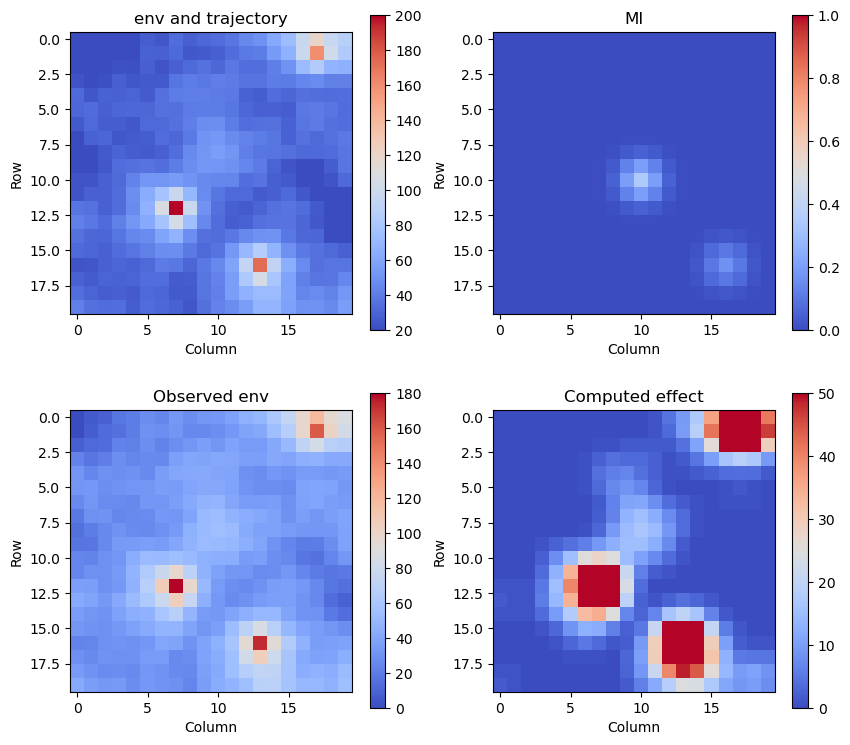

In [13]:
from pypolo2.experiments import visualizer
ani = visualizer.visual(logger)

# Display the animation
from IPython.display import HTML
HTML(ani.to_jshtml())

In [14]:
import math
import numpy as np
Temp = 25
k = math.pow(0.75, 1 / 400)
k = math.pow(k, 100)
print(k * Temp)
delta_e_2 = -20
accept_prob = np.exp(delta_e_2 / (k * Temp))
print(k)
print(accept_prob)

23.26512147755254
0.9306048591021017
0.4233076982022872


In [15]:
Setting.RR

array([[ 5,  1, 60],
       [ 2, 14, 66],
       [10,  0, 42]])